# Surrogate-Based Operability Analysis of a Heat Exchanger using the DWSIM process simulator and a Multi-Layer Perceptron (MLP)


Author: Nicolas Spogis, Ph.D. (Founder & Lead Engineer — AI4Tech)


This notebook presents a **realistic industrial workflow** for **operability / flexibility analysis** using **Opyrability**, combining:
- a **first-principles (phenomenological) model** executed in **DWSIM** via automation,
- a **data-driven surrogate model** (MLP, *scikit-learn*) trained from simulation data,
- and the core operability steps: **forward mapping** (AIS → AOS), **Operability Index**, and **inverse mapping** (DOS → DIS\*).

The goal is to quantify **what the process can achieve** (outputs) given **what we can vary** (inputs), and to estimate **which input settings** can satisfy **desired operating specifications**.

---

## Case Study: Process Cooler (Heat Exchanger)

We analyze a single **process cooler** where a hot stream is cooled by a cooling-water utility.
The operational behavior is evaluated in terms of **thermal performance** and **operational feasibility** across a range of disturbances and manipulated actions.

<p align="center">
  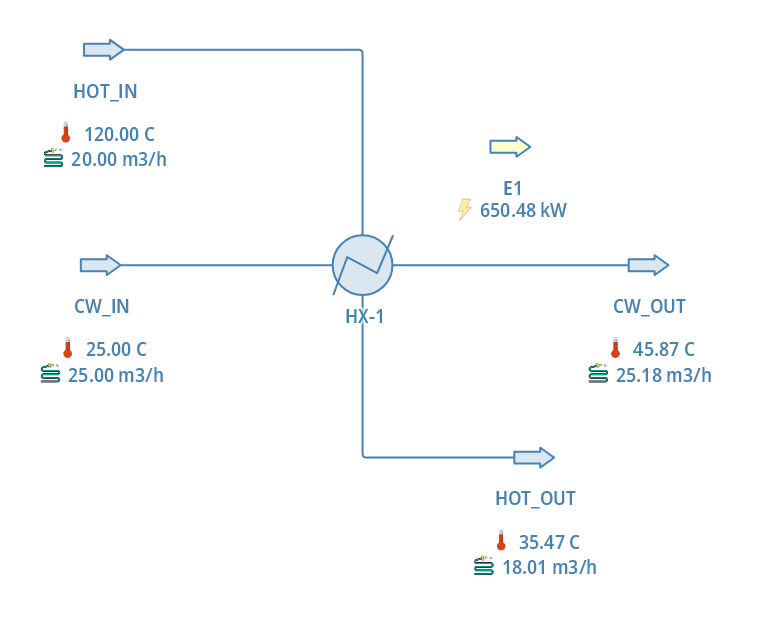
</p>

<p align="center">
  <em>
    Figure 1 – DWSIM flowsheet of the process cooling heat exchanger used as the
    first-principles (phenomenological) model. The hot stream is cooled by a
    cooling-water utility, and the resulting outlet temperature and heat duty
    are used for operability analysis.
  </em>
</p>

### Inputs and Outputs

The performed analysis maps the relationship between the **Available Input Set (AIS)** and the
**Achievable Output Set (AOS)**, as summarized below.

| Variable | Set | Type | Unit | Description |
|---|---|---|---|---|
| `T_h_in` | AIS | Disturbance | °C | Hot-stream inlet temperature (feed disturbance) |
| `m_cw` | AIS | Manipulated | m³/h | Cooling-water flowrate (control variable) |
| `T_h_out` | AOS | Output | °C | Hot-stream outlet temperature (product / quality specification proxy) |
| `Q` | AOS | Output | kW | Heat duty removed (utility / thermal performance proxy) |


> **Interpretation**
> - **AIS** defines the “knobs” and disturbances we allow the system to experience (the *input envelope*).
> - **AOS** represents the set of all outputs the system can produce under that AIS (the *output envelope*).

---

## Output Variable Definitions

- **`T_h_out` (Hot outlet temperature) [°C]**
  A direct **specification proxy** for cooling performance. Lower values generally indicate stronger cooling, but feasibility depends on available heat-transfer driving force and `m_cw`.

- **`Q` (Heat duty removed) [kW]**
  A **utility/performance proxy** representing how much thermal energy is removed from the hot stream by the exchanger.
  In DWSIM, this is typically read from the heat exchanger results (or equivalent energy balance variables).

---

## Modeling + Surrogate Strategy

### 1) DWSIM phenomenological model (ground truth)
A DWSIM flowsheet is used as the **reference simulator** to compute `T_h_out` and `Q` for many combinations of `T_h_in` and `m_cw`.
This generates a dataset covering the AIS domain.

*Figure 1: DWSIM flowsheet for the process cooling heat exchanger.*

### 2) MLP surrogate model (fast evaluator)
A **Multilayer Perceptron (MLP)** is trained to learn the mapping:

$\mathbf{u} = [T_{h,\mathrm{in}},\; m_{cw}]^\top \;\rightarrow\; \mathbf{y} = [T_{h,\mathrm{out}},\; Q]^\top$.

Once trained, the surrogate provides **fast evaluations** needed by operability routines (dense grids, inverse mapping, feasibility scans), while preserving the DWSIM behavior within the trained domain.

### 3) Operability workflow (Opyrability)
We then compute:
- **Forward mapping (AIS → AOS):** what output region is reachable from the defined input region;
- **Operability Index:** how much of a desired region is achievable (or, conversely, how restrictive the process is);
- **Inverse mapping (DOS → DIS\*):** which input region can satisfy a **desired output specification**.

---

## Requirements

This notebook assumes:
- **DWSIM installed** and accessible for automation (Windows/COM scenario is the most common),
- Python packages (minimum):
  - `opyrability`
  - `numpy`
  - `matplotlib`
  - `scikit-learn`
  - `pythonnet` (DWSIM COM automation / .NET bridge)

---

## Next Step

Let’s start by importing the necessary libraries:


In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import qmc

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from opyrability import AIS2AOS_map, multimodel_rep, OI_eval, nlp_based_approach


## Connecting to DWSIM

In this step, we load the required **DWSIM libraries** and establish a connection to the
process simulation environment.

This connection allows Python to:
- programmatically load and manipulate the flowsheet,
- modify operating conditions (inputs),
- execute simulations,
- and retrieve results for data generation and analysis.

> **Important:**
> The DWSIM installation path must be updated to match your local system configuration
> before running this section of the notebook.




In [2]:
# Set your DWSIM installation path
DWSIM_PATH = "C:\\Users\\[YourUser]\\AppData\\Local\\DWSIM\\" # Update this path

FLOWSHEET_FILE = "heat_exchanger.dwxmz"

In [3]:
import pythoncom
pythoncom.CoInitialize()

import clr

clr.AddReference(str(DWSIM_PATH) + r"\CapeOpen.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.Automation.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.Interfaces.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.GlobalSettings.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.SharedClasses.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.Thermodynamics.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.UnitOperations.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.Inspector.dll")
clr.AddReference(str(DWSIM_PATH) + r"\System.Buffers.dll")
clr.AddReference(str(DWSIM_PATH) + r"\DWSIM.Thermodynamics.ThermoC.dll")

In [4]:
from DWSIM.Automation import Automation3

def open_DWSIM(flowsheet_file: str):
    manager = Automation3()
    fs = manager.LoadFlowsheet(flowsheet_file)
    return manager, fs

manager, myflowsheet = open_DWSIM(FLOWSHEET_FILE)
print(f"DWSIM flowsheet loaded -> {FLOWSHEET_FILE}")

DWSIM flowsheet loaded -> heat_exchanger.dwxmz


## Read and Save Snapshot Definitions

In this section, we load previously saved **snapshot definitions** that describe the
structure and state of the DWSIM flowsheet.

These snapshots are used to:
- ensure consistency when reloading the simulation,
- restore unit operations, streams, and thermodynamic settings,
- and enable reproducible execution of the process model during automated runs.

The snapshot data is also saved for future reuse, allowing the simulation setup to be
recovered without manually rebuilding the flowsheet.


In [5]:
def SaveSnapshot(DWSIM_PATH, myflowsheet):
    clr.AddReference(DWSIM_PATH + "\\DWSIM.Interfaces.dll")
    from DWSIM.Interfaces.Enums import SnapshotType
    Type = SnapshotType.ObjectData
    snap = myflowsheet.GetSnapshot(Type)
    return snap

def ReadSnapshot(DWSIM_PATH, snap, myflowsheet):
    clr.AddReference(DWSIM_PATH + "\\DWSIM.Interfaces.dll")
    from DWSIM.Interfaces.Enums import SnapshotType
    Type = SnapshotType.ObjectData
    myflowsheet.RestoreSnapshot(snap, Type)
    return snap

In [25]:
Snapshot = SaveSnapshot(DWSIM_PATH, myflowsheet)
print(f"DWSIM Snapshot saved!")

DWSIM Snapshot saved!


## Phenomenological Model Wrapper (DWSIM)

In this step, we define a **Python wrapper** around the DWSIM flowsheet, which exposes the
phenomenological model as a callable function.

The wrapper function `hx_problem(u)`:
- receives the input vector
  `u = [T_h_in (°C), m_cw (m³/h)]`,
- updates the corresponding variables in the DWSIM model,
- runs the simulation,
- and returns the output vector
  `y = [T_h_out (°C), Q (kW)]`.

This function provides a clean and consistent interface between the **first-principles
process model** and the **surrogate modeling / operability analysis** workflows that follow.



In [7]:
OBJ_HOT_IN_STREAM = "HOT_IN"
OBJ_CW_IN_STREAM = "CW_IN"
OBJ_HOT_OUT_STREAM = "HOT_OUT"
OBJ_DUTY_OBJECT = "E1"

In [8]:
def hx_problem(Input_Parameters):
    global manager, myflowsheet, Snapshot, DWSIM_PATH

    #Read Snapshot
    ReadSnapshot(DWSIM_PATH, Snapshot, myflowsheet)
    Th_in_C = Input_Parameters[0]
    cw_in_m3h = Input_Parameters[1]

    try:
        # Set hot inlet temperature (DWSIM uses Kelvin)
        hot_in = myflowsheet.GetFlowsheetSimulationObject(OBJ_HOT_IN_STREAM).GetAsObject()
        hot_in.SetTemperature(Th_in_C + 273.15)

        # Set cooling water flow  (DWSIM uses m3/s)
        cw_in = myflowsheet.GetFlowsheetSimulationObject(OBJ_CW_IN_STREAM).GetAsObject()
        cw_in.SetVolumetricFlow(cw_in_m3h/3600)

        # Solve flowsheet
        errors = manager.CalculateFlowsheet4(myflowsheet)

        # Spreadsheet recalc
        try:
            mySpreadsheet = myflowsheet.GetSpreadsheetObject()
            mySpreadsheet.Worksheets[0].Recalculate()
        except Exception:
            pass

        if errors is not None and len(errors) > 0:
            return np.array([np.nan, np.nan], dtype=float)

        # Read outputs
        hot_out = myflowsheet.GetFlowsheetSimulationObject(OBJ_HOT_OUT_STREAM).GetAsObject()
        Th_out_C = hot_out.GetTemperature() - 273.15

        duty_obj = myflowsheet.GetFlowsheetSimulationObject(OBJ_DUTY_OBJECT).GetAsObject()
        Q = duty_obj.GetEnergyFlow()

        return np.array([float(Th_out_C), float(Q)], dtype=float)

    except Exception:
        return np.array([np.nan, np.nan], dtype=float)


### Quick Sanity Check

Before proceeding with large-scale data generation and surrogate training,
we perform a quick sanity check to verify that:
- the DWSIM connection is working correctly,
- the wrapper function executes without errors,
- and the returned outputs are physically consistent and within expected ranges.

This step helps catch configuration or modeling issues early,
preventing unnecessary computational effort in later stages.



In [9]:
tests = [
    np.array([80.0,  5.0]),
    np.array([80.0, 25.0]),
    np.array([120.0, 5.0]),
    np.array([120.0, 25.0]),
]
for u in tests:
    print(u, "->", hx_problem(u))


[80.  5.] -> [ 44.00988 280.80248]
[80. 25.] -> [ 31.02828 376.02394]
[120.   5.] -> [ 58.31947 487.67613]
[120.  25.] -> [ 35.4697  650.48358]


## Define AIS and Forward Mapping with DWSIM

We now define the **Available Input Set (AIS)** by specifying the admissible ranges for
`T_h_in` and `m_cw`. Next, we compute the **forward map** (AIS → AOS) by evaluating the
DWSIM flowsheet across a grid of input combinations.

> **Note (computational cost):**
> Each grid point triggers a full flowsheet solve in DWSIM.
> Keep the grid resolution **small** in this section to ensure reasonable run time.


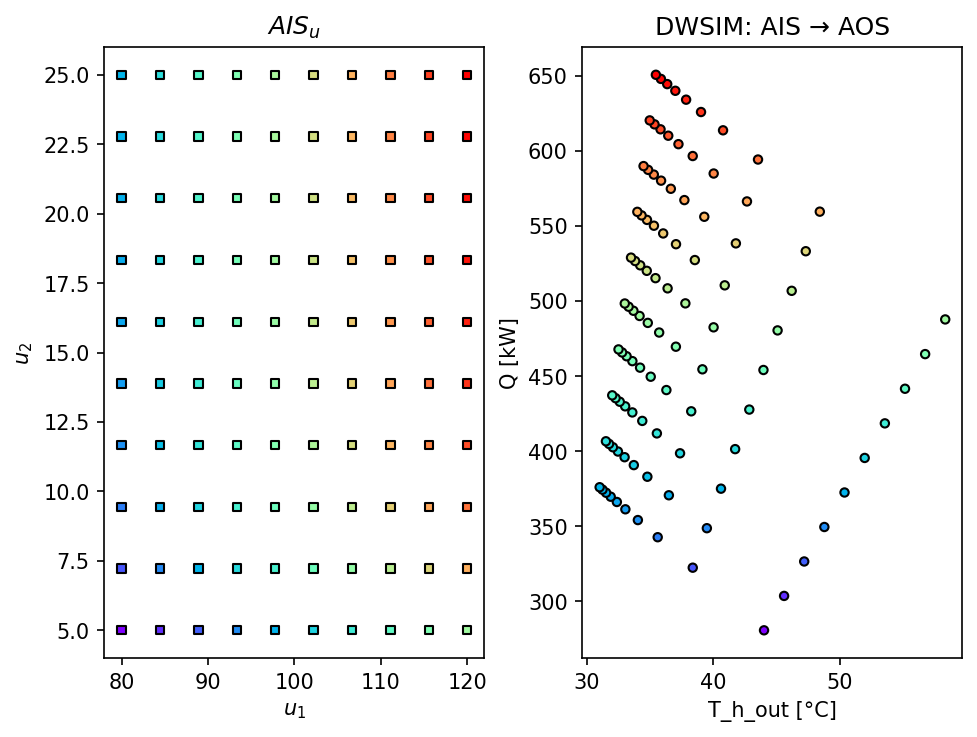

In [10]:
# ------------------------------------------------------------
# Define the Available Input Set (AIS)
# ------------------------------------------------------------
# Each row corresponds to one input variable:
#   [lower_bound, upper_bound]
#
# 1) T_h_in : Hot-stream inlet temperature [°C]
# 2) m_cw   : Cooling-water flowrate [m³/h]
AIS_bounds = np.array(
    [
        [80.0, 120.0],   # T_h_in [°C]
        [5.0, 25.0],     # m_cw [m³/h]
    ],
    dtype=float
)

# ------------------------------------------------------------
# Forward mapping resolution
# ------------------------------------------------------------
# Number of grid points per input dimension.
# Total number of DWSIM simulations = 10 × 10 = 100
resolution_fp = [10, 10]

# ------------------------------------------------------------
# Forward mapping: AIS → AOS using the DWSIM model
# ------------------------------------------------------------
AIS_fp, AOS_fp = AIS2AOS_map(
    hx_problem,      # phenomenological model wrapper
    AIS_bounds,      # input domain (AIS)
    resolution_fp,   # grid resolution
    plot=True        # plot AOS projection
)

# ------------------------------------------------------------
# Plot formatting
# ------------------------------------------------------------
plt.title("DWSIM: AIS → AOS")
plt.xlabel("T_h_out [°C]")
plt.ylabel("Q [kW]")
plt.show()



## Generate Training Data Using Latin Hypercube Sampling (LHS)

To efficiently generate training data for the surrogate model, we employ
**Latin Hypercube Sampling (LHS)** over the defined **AIS domain**.

LHS provides a space-filling sampling strategy that:
- ensures good coverage of the input space with a limited number of samples,
- avoids clustering of points typical of purely random sampling,
- and is well suited for surrogate modeling in nonlinear process systems.

Each sampled point is evaluated using the DWSIM phenomenological model,
producing input–output pairs that will be used to train the MLP surrogate.



In [11]:
n_samples = 1000  # increase if your flowsheet is fast

sampler = qmc.LatinHypercube(d=2, seed=42)
X_unit = sampler.random(n=n_samples)

X = qmc.scale(
    X_unit,
    l_bounds=[AIS_bounds[0,0]*0.9, AIS_bounds[1,0]*0.9],
    u_bounds=[AIS_bounds[0,1]*1.1, AIS_bounds[1,1]*1.1]
)

Y = np.zeros((n_samples, 2), dtype=float)

t0 = time.time()
valid = 0
for i in range(n_samples):
    Y[i, :] = hx_problem(X[i, :])
    if np.all(np.isfinite(Y[i, :])):
        valid += 1
    if (i + 1) % 25 == 0:
        print(f"{i+1}/{n_samples} evaluated | valid={valid}")

print(f"Elapsed: {time.time()-t0:.1f} s")

mask = np.all(np.isfinite(Y), axis=1)
X = X[mask]
Y = Y[mask]
print("Filtered dataset:", X.shape, Y.shape)


25/1000 evaluated | valid=25
50/1000 evaluated | valid=50
75/1000 evaluated | valid=75
100/1000 evaluated | valid=100
125/1000 evaluated | valid=125
150/1000 evaluated | valid=150
175/1000 evaluated | valid=175
200/1000 evaluated | valid=200
225/1000 evaluated | valid=225
250/1000 evaluated | valid=250
275/1000 evaluated | valid=275
300/1000 evaluated | valid=300
325/1000 evaluated | valid=325
350/1000 evaluated | valid=350
375/1000 evaluated | valid=375
400/1000 evaluated | valid=400
425/1000 evaluated | valid=425
450/1000 evaluated | valid=450
475/1000 evaluated | valid=475
500/1000 evaluated | valid=500
525/1000 evaluated | valid=525
550/1000 evaluated | valid=550
575/1000 evaluated | valid=575
600/1000 evaluated | valid=600
625/1000 evaluated | valid=625
650/1000 evaluated | valid=650
675/1000 evaluated | valid=675
700/1000 evaluated | valid=700
725/1000 evaluated | valid=725
750/1000 evaluated | valid=750
775/1000 evaluated | valid=775
800/1000 evaluated | valid=800
825/1000 evalu

## Train a Multi-Output MLP Surrogate Model

In this step, we train a **multi-output Multilayer Perceptron (MLP)** to approximate the
input–output behavior of the DWSIM phenomenological model.

Both **inputs and outputs are scaled** prior to training in order to:
- improve numerical conditioning,
- stabilize gradient-based optimization,
- and ensure balanced learning across variables with different magnitudes and units.

The trained surrogate provides a fast and smooth approximation of the process behavior,
making it suitable for forward mapping, inverse mapping, and operability analysis.



In [12]:
# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42
)

# Scaling (important for smooth tanh MLP + inverse optimization stability)
scalerX = StandardScaler()
scalerY = StandardScaler()

Xtr = scalerX.fit_transform(X_train)
Ytr = scalerY.fit_transform(Y_train)

Xte = scalerX.transform(X_test)

# Robust MLP for inverse operability (smooth + regularized + early stopping)
mlp = MLPRegressor(
    hidden_layer_sizes=(32, 32),
    activation="tanh",
    solver="adam",
    alpha=1e-3,
    learning_rate_init=5e-4,
    max_iter=8000,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=30,
    tol=1e-6,
    random_state=42
)

mlp.fit(Xtr, Ytr)

# Predict (bring back to physical units)
Y_pred = scalerY.inverse_transform(mlp.predict(Xte))

# Metrics
print("R2 T_h_out:", r2_score(Y_test[:, 0], Y_pred[:, 0]))
print("R2 Q      :", r2_score(Y_test[:, 1], Y_pred[:, 1]))

print("RMSE T_h_out:", np.sqrt(mean_squared_error(Y_test[:, 0], Y_pred[:, 0])))
print("RMSE Q      :", np.sqrt(mean_squared_error(Y_test[:, 1], Y_pred[:, 1])))


R2 T_h_out: 0.9999017187923868
R2 Q      : 0.9999500770253356
RMSE T_h_out: 0.062169743745055496
RMSE Q      : 0.8493156096183071


## Surrogate Model Wrapper and Forward Mapping (AIS → AOS)

In this section, we wrap the trained **MLP surrogate model** into a callable function
that mirrors the interface of the phenomenological DWSIM model.

This surrogate wrapper:
- receives the same input vector `u = [T_h_in, m_cw]`,
- applies the appropriate input scaling,
- evaluates the trained MLP,
- and returns the predicted outputs in physical units.

Using this wrapper, we compute the **forward map (AIS → AOS)** efficiently,
allowing dense sampling and visualization of the achievable output space
without the computational cost of repeatedly solving the DWSIM flowsheet.


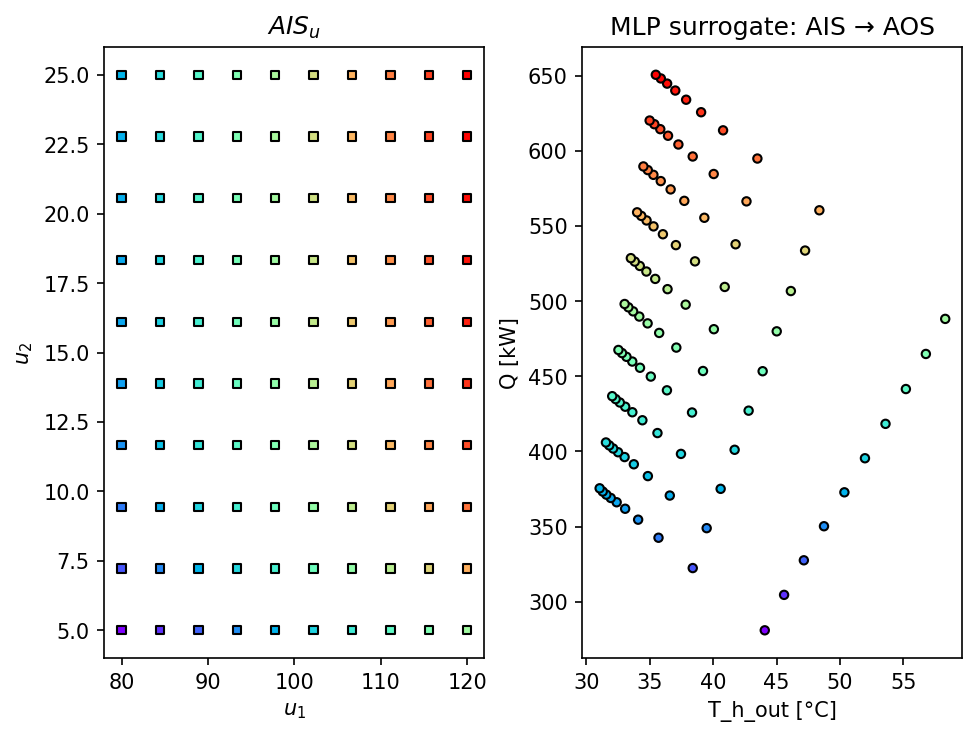

In [13]:
def mlp_surrogate(u):
    u = np.asarray(u, dtype=float).reshape(1, -1)
    y_scaled = mlp.predict(scalerX.transform(u))
    y = scalerY.inverse_transform(y_scaled)
    return y.reshape(-1)

resolution_surr = [10, 10]
AIS_s, AOS_s = AIS2AOS_map(mlp_surrogate, AIS_bounds, resolution_surr, plot=True)

plt.title("MLP surrogate: AIS → AOS")
plt.xlabel("T_h_out [°C]")
plt.ylabel("Q [kW]")
plt.show()


## Operability Index (OI)

The **Operability Index (OI)** quantifies how much of a **desired operating region**
in the output space can be achieved by the process given the defined **AIS**.

In practical terms, the OI measures:
- the degree of operational flexibility of the system,
- how restrictive the process is with respect to output specifications,
- and whether the desired performance targets are realistically attainable.

An OI value close to **1** indicates high operability (most of the desired region is
reachable), while values close to **0** indicate limited or poor operability.

In this notebook, the OI is computed using the surrogate-based AOS,
enabling efficient evaluation of different operating specifications.



In [14]:
# ------------------------------------------------------------
# Define the Desired Output Set (DOS)
# ------------------------------------------------------------
# Each row corresponds to one output variable:
#   [lower_bound, upper_bound]
#
# 1) T_h_out : Desired range for hot-stream outlet temperature [°C]
#              Represents the target cooling specification.
#
# 2) Q       : Desired range for heat duty removed [kW]
#              Represents acceptable thermal/utility performance.
DOS_bounds = np.array(
    [
        [35.0, 40.0],    # T_h_out [°C]
        [300.0, 500.0],  # Q [kW]
    ],
    dtype=float
)




Computing AOS using the first-principles (DWSIM) model...


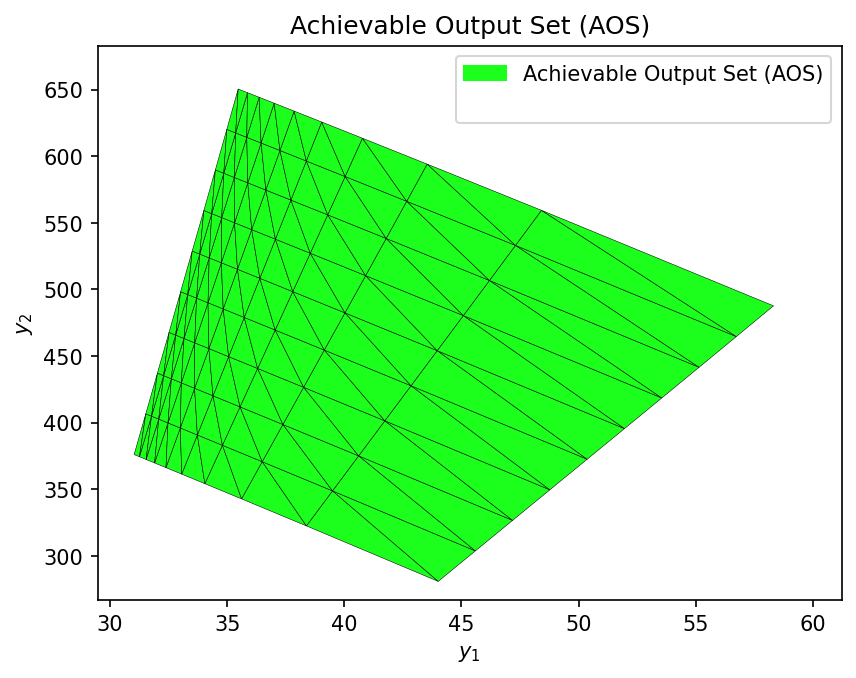

  Completed in 2.44 seconds

Computing AOS using the MLP surrogate model...


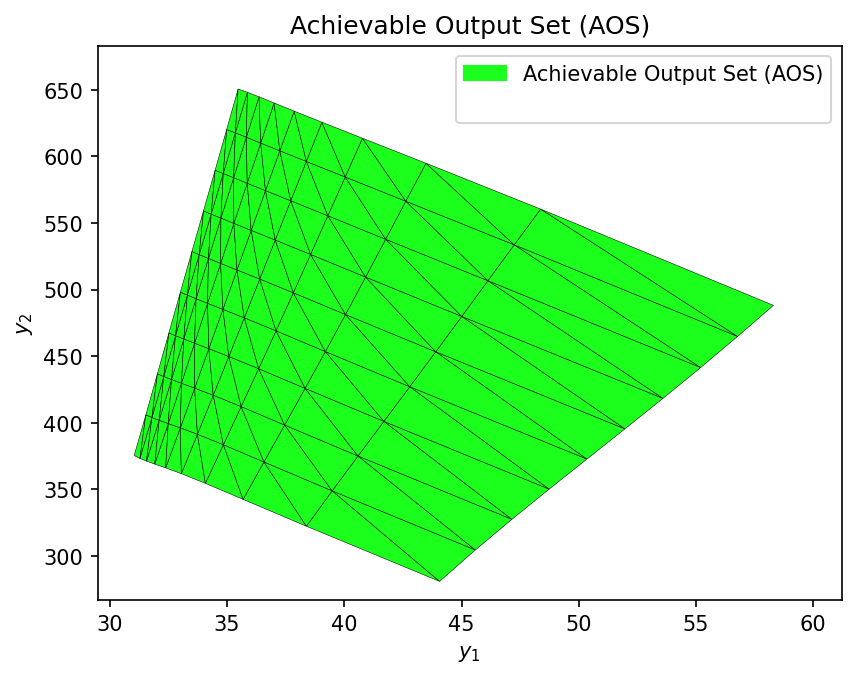

  Completed in 0.38 seconds


In [15]:
# ------------------------------------------------------------
# Define AIS resolution for multimodel representation
# ------------------------------------------------------------
# Number of discretization points per AIS dimension.
# This grid is used to compute the Achievable Output Set (AOS)
# using different process models.
AIS_resolution = [10, 10]

# ------------------------------------------------------------
# Multimodel AOS computation — First-principles (DWSIM) model
# ------------------------------------------------------------
print("\nComputing AOS using the first-principles (DWSIM) model...")
start_fp_mm = time.time()

AOS_fp = multimodel_rep(
    hx_problem,      # phenomenological model wrapper
    AIS_bounds,      # AIS domain
    AIS_resolution   # discretization resolution
)

time_fp_mm = time.time() - start_fp_mm
print(f"  Completed in {time_fp_mm:.2f} seconds")

# ------------------------------------------------------------
# Multimodel AOS computation — Surrogate (MLP) model
# ------------------------------------------------------------
print("\nComputing AOS using the MLP surrogate model...")
start_surr_mm = time.time()

AOS_surr = multimodel_rep(
    mlp_surrogate,   # trained surrogate model wrapper
    AIS_bounds,      # AIS domain
    AIS_resolution   # discretization resolution
)

time_surr_mm = time.time() - start_surr_mm
print(f"  Completed in {time_surr_mm:.2f} seconds")


**First-Principles Model — Operability Index (OI)**


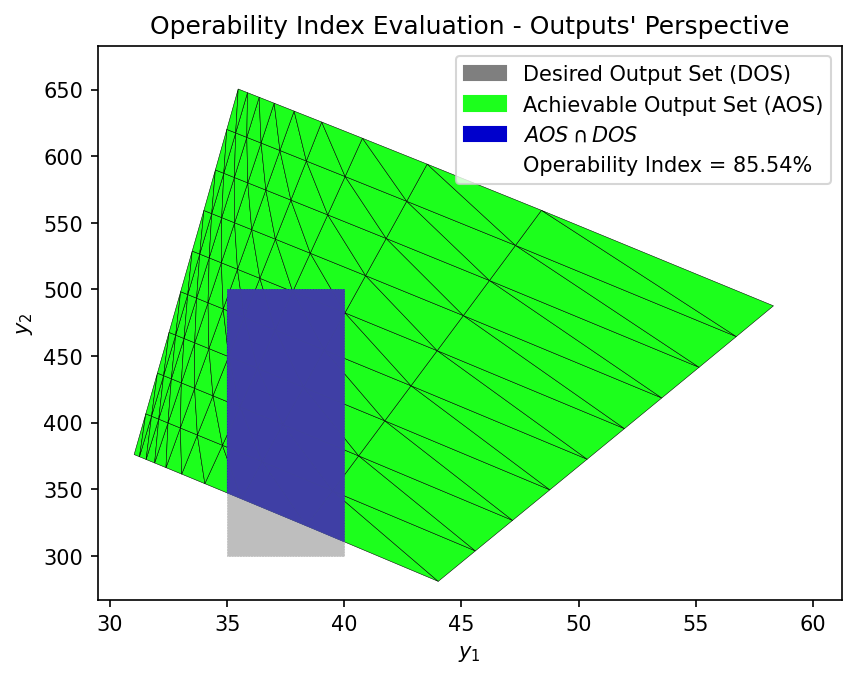

In [16]:
OI_fp = OI_eval(AOS_fp, DOS_bounds, plot=True)

**Operability Index (OI) — Surrogate Model**

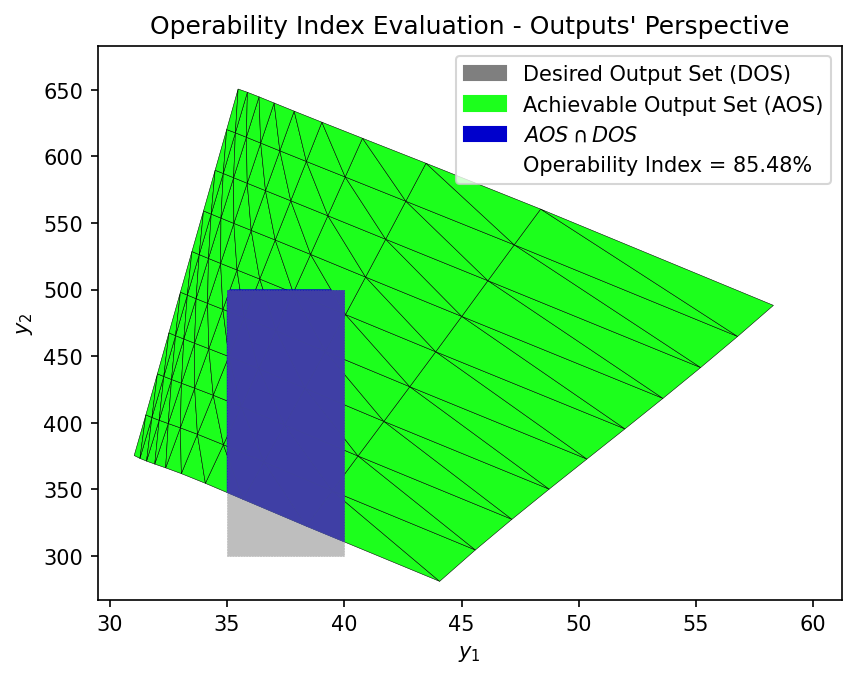

In [17]:
OI_surr = OI_eval(AOS_surr, DOS_bounds, plot=True)


In [18]:
# ------------------------------------------------------------
# Operability Index (OI) comparison summary
# ------------------------------------------------------------
# This section compares:
#  - OI computed with the first-principles (DWSIM) model
#  - OI computed with the surrogate (MLP / GP) model
#  - Computational cost of each approach
# ------------------------------------------------------------

print("\n" + "=" * 60)
print("OPERABILITY INDEX COMPARISON")
print("=" * 60)

# Table header
print(
    f"\n  {'Metric':<25}"
    f"{'First-Principles':>18}"
    f"{'Surrogate Model':>18}"
)

# Separator
print(
    f"  {'-'*25}"
    f"{'-'*18}"
    f"{'-'*18}"
)

# Operability Index values
print(
    f"  {'OI Value':<25}"
    f"{OI_fp:>17.2f}%"
    f"{OI_surr:>17.2f}%"
)

# Multimodel computation time
print(
    f"  {'Multimodel Time [s]':<25}"
    f"{time_fp_mm:>18.2f}"
    f"{time_surr_mm:>18.2f}"
)

# ------------------------------------------------------------
# Accuracy and performance metrics
# ------------------------------------------------------------

# Relative error between OI values
relative_error_oi = abs(OI_fp - OI_surr) / OI_fp * 100

# Speedup factor of surrogate vs first-principles
speedup = time_fp_mm / time_surr_mm

print(f"\n  Relative Error in OI: {relative_error_oi:.2f}%")
print(f"  Speedup: {speedup:.1f}× faster")



OPERABILITY INDEX COMPARISON

  Metric                     First-Principles   Surrogate Model
  -------------------------------------------------------------
  OI Value                             85.54%            85.48%
  Multimodel Time [s]                    2.44              0.38

  Relative Error in OI: 0.07%
  Speedup: 6.4× faster


## Inverse Mapping (DOS → DIS\*) via Nonlinear Programming (NLP)

In this section, we perform the **inverse operability analysis**, where the goal is to
determine the set of input conditions that can achieve a **Desired Output Set (DOS)**.

Instead of mapping inputs to outputs, we solve the inverse problem:
given a target region in the output space, find the corresponding **Desired Input Set**
that satisfies these specifications.

This inverse mapping is formulated as a **nonlinear programming (NLP)** problem,
typically solved using the **surrogate model** to ensure computational efficiency.

The resulting **DIS\*** represents the subset of the AIS that can reliably drive the
process into the desired operating region.


**First-Principles Model (DWSIM)**

Running inverse mapping with First-Principles Model...


100%|██████████| 100/100 [03:13<00:00,  1.94s/it]


Completed in 193.73 seconds


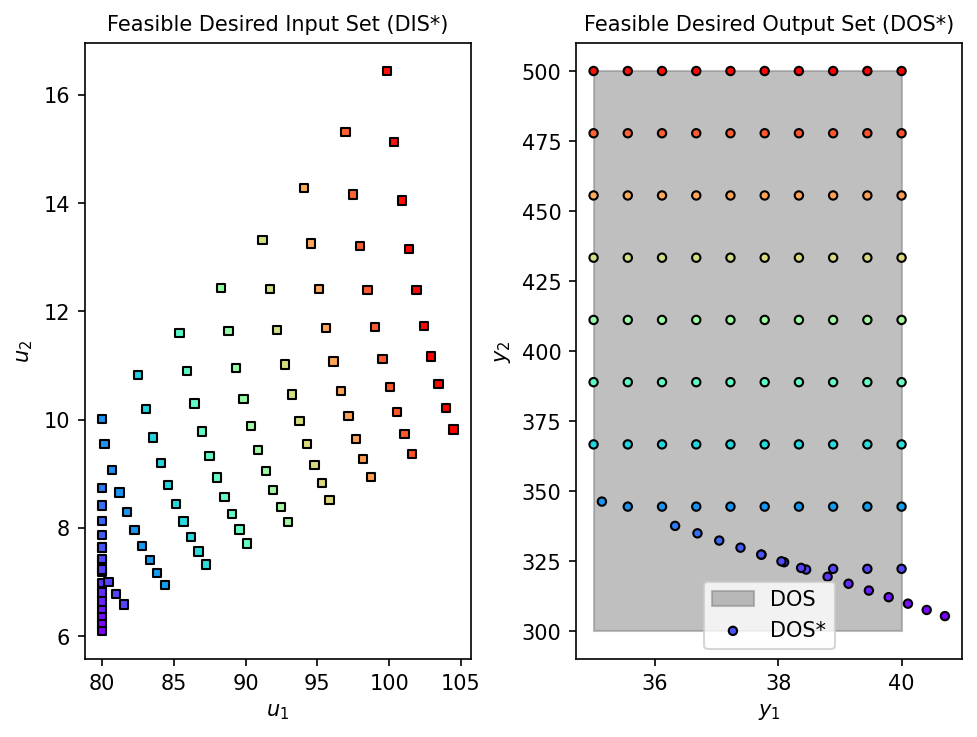

In [19]:
DOS_resolution = [10, 10]

lb = np.array([AIS_bounds[0,0], AIS_bounds[1,0]], dtype=float)
ub = np.array([AIS_bounds[0,1], AIS_bounds[1,1]], dtype=float)
u0 = 0.5 * (lb + ub)

# Inverse mapping with First-Principles Model
print("Running inverse mapping with First-Principles Model...")
start_fp = time.time()
fDIS_fp, fDOS_fp, conv_fp = nlp_based_approach(
    hx_problem, DOS_bounds, DOS_resolution, u0, lb, ub,
    constr=None, method='ipopt', plot=True, ad=False, warmstart=False
)
time_fp = time.time() - start_fp
print(f"Completed in {time_fp:.2f} seconds")

**Surrogate Model (MLP)**

Running inverse mapping with MLP Surrogate Model...


100%|██████████| 100/100 [00:03<00:00, 26.58it/s]


Completed in 3.78 seconds


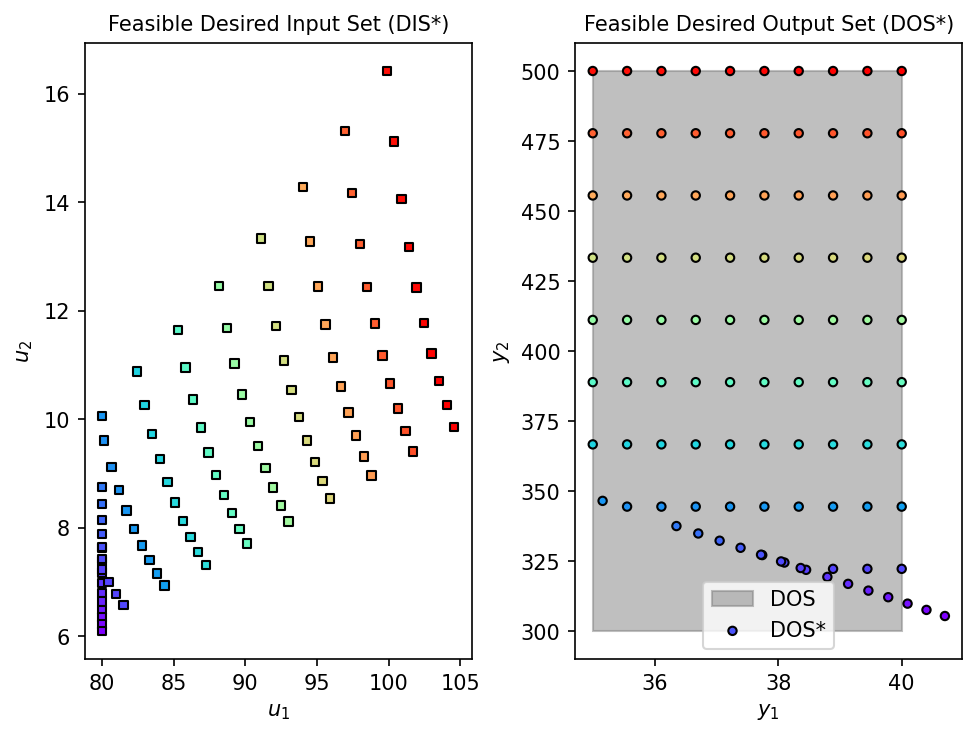

In [20]:
DOS_resolution = [10, 10]

lb = np.array([AIS_bounds[0,0], AIS_bounds[1,0]], dtype=float)
ub = np.array([AIS_bounds[0,1], AIS_bounds[1,1]], dtype=float)
u0 = 0.5 * (lb + ub)

# Inverse mapping with MLP Surrogate Model
print("Running inverse mapping with MLP Surrogate Model...")
start_surr = time.time()
fDIS_surr, fDOS_surr, conv_fp = nlp_based_approach(
    mlp_surrogate, DOS_bounds, DOS_resolution, u0, lb, ub,
    constr=None, method='ipopt', plot=True, ad=False, warmstart=False
)
time_surrogate = time.time() - start_surr
print(f"Completed in {time_surrogate:.2f} seconds")

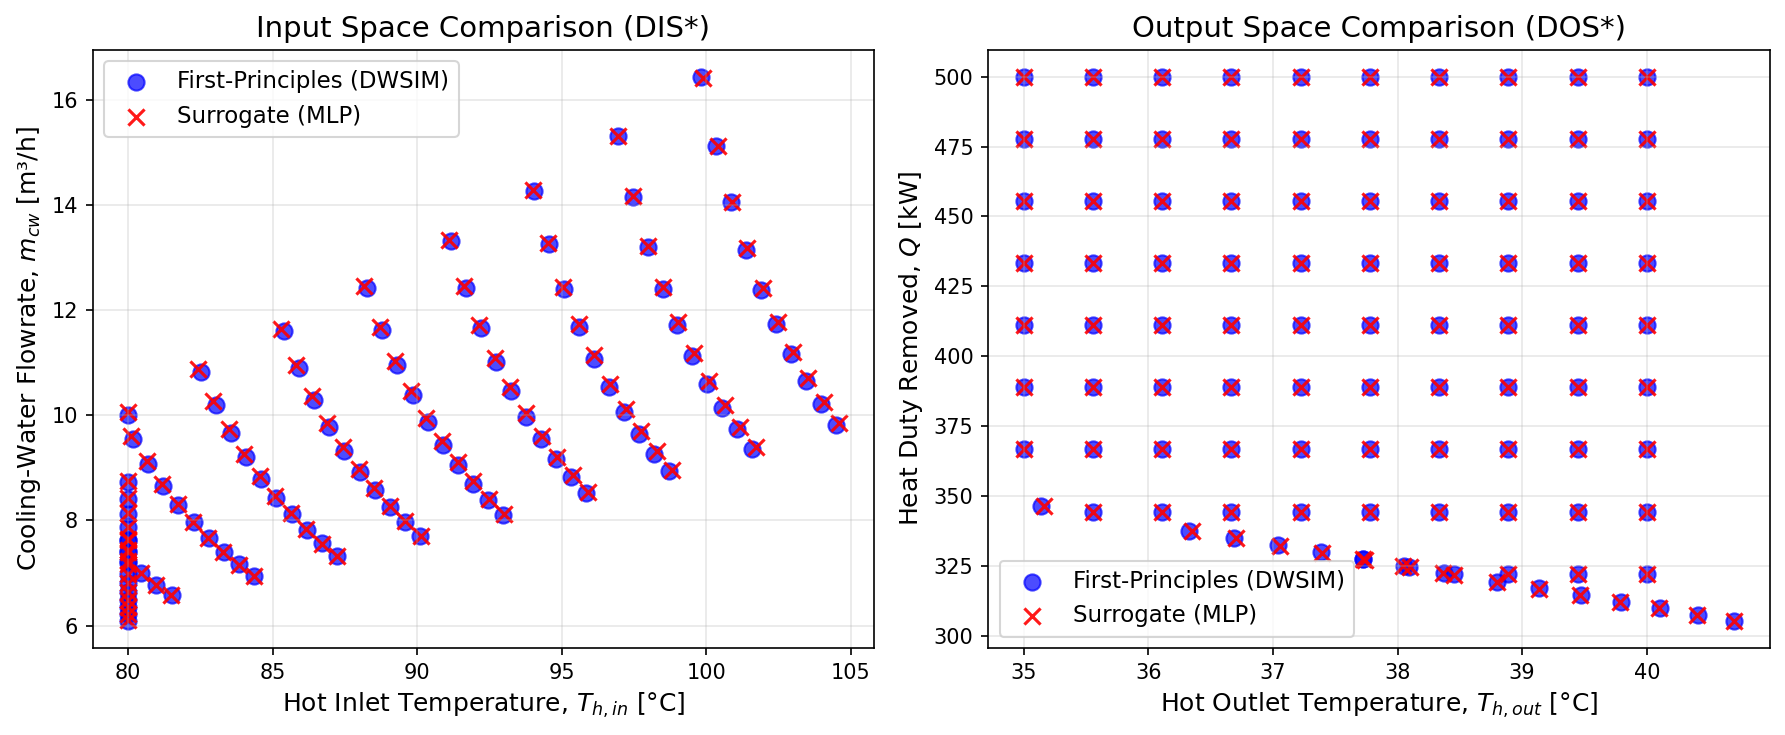

In [21]:
# ------------------------------------------------------------
# Overlay plot: Visual comparison of DIS* and DOS*
# First-principles (DWSIM) vs Surrogate (MLP)
# ------------------------------------------------------------

# Filter feasible points (remove None entries)
dis_fp = np.array([u for u in fDIS_fp if u is not None])
dis_surr = np.array([u for u in fDIS_surr if u is not None])

dos_fp = np.array([y for y in fDOS_fp if y is not None])
dos_surr = np.array([y for y in fDOS_surr if y is not None])

# ------------------------------------------------------------
# Create side-by-side plots
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ------------------------------------------------------------
# DIS* overlay — Input (design/operating) space
# ------------------------------------------------------------
axes[0].scatter(
    dis_fp[:, 0], dis_fp[:, 1],
    c='blue', s=60, alpha=0.7, label='First-Principles (DWSIM)'
)
axes[0].scatter(
    dis_surr[:, 0], dis_surr[:, 1],
    c='red', marker='x', s=60, alpha=0.9, label='Surrogate (MLP)'
)

axes[0].set_xlabel('Hot Inlet Temperature, $T_{h,in}$ [°C]', fontsize=12)
axes[0].set_ylabel('Cooling-Water Flowrate, $m_{cw}$ [m³/h]', fontsize=12)
axes[0].set_title('Input Space Comparison (DIS*)', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# ------------------------------------------------------------
# DOS* overlay — Output (performance/specification) space
# ------------------------------------------------------------
axes[1].scatter(
    dos_fp[:, 0], dos_fp[:, 1],
    c='blue', s=60, alpha=0.7, label='First-Principles (DWSIM)'
)
axes[1].scatter(
    dos_surr[:, 0], dos_surr[:, 1],
    c='red', marker='x', s=60, alpha=0.9, label='Surrogate (MLP)'
)

axes[1].set_xlabel('Hot Outlet Temperature, $T_{h,out}$ [°C]', fontsize=12)
axes[1].set_ylabel('Heat Duty Removed, $Q$ [kW]', fontsize=12)
axes[1].set_title('Output Space Comparison (DOS*)', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# ------------------------------------------------------------
# Final layout
# ------------------------------------------------------------
plt.tight_layout()
plt.show()


## Compute Representative Design Point from DIS\*

In this final step, we compute a **representative design/operating point** from the
feasible **Desired Input Set (DIS\*)**.

The mean values of the DIS\* are used as a:
- nominal operating point,
- reference design condition,
- or initial guess for further optimization or control studies.

This provides a concise summary of the inverse operability results and a practical
setpoint that satisfies the desired output specifications.

In [24]:
print("\nMean Design Values from DIS*:\n")

# Column widths
w_var = 38
w_fp  = 26
w_su  = 20
w_er  = 12

# Header
print(
    f"{'Variable':<{w_var}}"
    f"{'First-Principles (DWSIM)':>{w_fp}}"
    f"{'MLP Surrogate':>{w_su}}"
    f"{'Rel. Error':>{w_er}}"
)

# Separator
print(
    f"{'-'*w_var}"
    f"{'-'*w_fp}"
    f"{'-'*w_su}"
    f"{'-'*w_er}"
)

# Rows
print(
    f"{'Hot inlet temperature, T_h,in [°C]':<{w_var}}"
    f"{mean_Thin_fp:>{w_fp}.4f}"
    f"{mean_Thin_surr:>{w_su}.4f}"
    f"{abs(mean_Thin_fp - mean_Thin_surr)/mean_Thin_fp*100:>{w_er-1}.4f}%"
)

print(
    f"{'Cooling-water flowrate, m_cw [m³/h]':<{w_var}}"
    f"{mean_mcw_fp:>{w_fp}.4f}"
    f"{mean_mcw_surr:>{w_su}.4f}"
    f"{abs(mean_mcw_fp - mean_mcw_surr)/mean_mcw_fp*100:>{w_er-1}.4f}%"
)

# ------------------------------------------------------------
# Computational performance
# ------------------------------------------------------------
print("\nComputational Time:\n")

print(f"{'First-Principles (DWSIM):':<{w_var}} {time_fp:>10.2f} s")
print(f"{'MLP Surrogate:':<{w_var}} {time_surrogate:>10.2f} s")
print(f"{'Speedup:':<{w_var}} {time_fp/time_surrogate:>10.1f}× faster")



Mean Design Values from DIS*:

Variable                                First-Principles (DWSIM)       MLP Surrogate  Rel. Error
------------------------------------------------------------------------------------------------
Hot inlet temperature, T_h,in [°C]                       89.6892             89.6894     0.0002%
Cooling-water flowrate, m_cw [m³/h]                       9.6515              9.6847     0.3441%

Computational Time:

First-Principles (DWSIM):                  193.73 s
MLP Surrogate:                               3.78 s
Speedup:                                     51.3× faster


## Conclusion

This case study demonstrates the effectiveness of **surrogate-based operability analysis**
for realistic process engineering applications. By combining a **first-principles
phenomenological model** implemented in **DWSIM** with a **data-driven MLP surrogate**,
it was possible to accurately characterize the operational behavior of a process heat
exchanger across a wide range of conditions.

The results show that the surrogate model is able to **reproduce the achievable output
space and the Operability Index** obtained from the high-fidelity DWSIM model with very
low error, while providing a **computational speedup of more than one order of magnitude**.
This performance gain enables dense forward mappings, efficient inverse mappings, and
rapid feasibility assessments that would otherwise be impractical using only
first-principles simulations.

Through the computation of the **Operability Index** and the **inverse mapping
(DOS → DIS\*)**, the analysis provides not only a quantitative measure of process
flexibility, but also practical insights into which input conditions can reliably satisfy
desired operating specifications. The resulting DIS\* offers actionable guidance for
design, operation, and decision-making under uncertainty.

Overall, this example highlights how the integration of **process simulation,
machine-learning surrogates, and operability analysis tools such as Opyrability** forms a
powerful framework for modern process engineering, bridging the gap between rigorous
models and computationally efficient analysis workflows.


**Acknowledgements**
This notebook reflects practical experience in industrial process simulation, surrogate
modeling, and operability analysis. The author acknowledges the open-source community
behind DWSIM, Opyrability, and scikit-learn for enabling reproducible and accessible
advanced process engineering workflows.